In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

from solardatatools import signal_decompositions as sd

np.random.seed(12) 

# Set up simple numerical examples for tests of  l2_l1d1_l2d2p365

In [2]:
# Create signal
t = np.linspace(0, 1000, 365*2)

signal1 = np.sin(2 * np.pi * t * 1 / (365.))  
signal2 = signal.square(2 * np.pi * t * 1 / (365.)) 
signal3 = 0.15 * np.random.randn(len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal3
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)

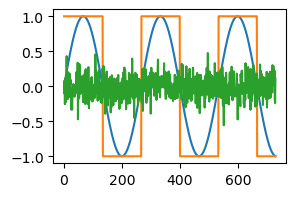

In [3]:
plt.figure(figsize=(3,2))
plt.plot(signal1)
plt.plot(signal2)
plt.plot(X_real[0]);

In [4]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [5]:
# make signal <365 for first few tests
signal_365 = test_df["test_signal"].array[:365]

Note: adjusted c1 from 10 (default) to 2 to make decompositions more reasonable 

### Default

In [6]:
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"] + ["expected_s_seas_mosek_365"] + ["expected_obj_val_mosek_365"]

### W/ weights

In [7]:
# Generate random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(rand_residual_weights), pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

# Pass residual weights to function
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", return_obj=True, 
                                             residual_weights=test_df["rand_residual_weights_365"].dropna())
# Add results to DF
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat),  pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365", "expected_obj_val_mosek_rw_365"]

# Pass tv_weights to function
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", return_obj=True, 
                                             tv_weights=test_df["rand_tv_weights_365"].dropna())
# Add results to DF
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat),  pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365", "expected_obj_val_mosek_tvw_365"]

### W/ transition pnt

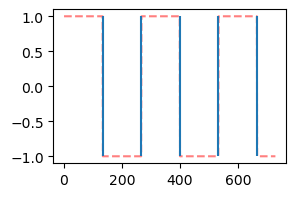

In [8]:
# get indices of piecewise fn transitions
plt.figure(figsize=(3,2))
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.vlines(133, -1, 1)
plt.vlines(266, -1, 1)
plt.vlines(399, -1, 1)
plt.vlines(532, -1, 1)
plt.vlines(665, -1, 1);

In [9]:
idx = [133, 266] # only up to index 365 since not taking the full signal in this test (len(signal)<365)

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx, return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_365", "expected_s_seas_mosek_transition_365", "expected_obj_val_mosek_transition_365"]

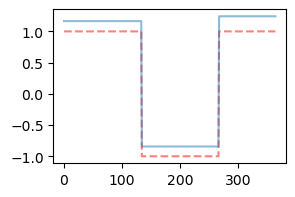

In [10]:
plt.figure(figsize=(3,2))
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_365"], alpha=0.5);

### W/ wrong transition indices

In [11]:
idx_wrong = [100, 308]

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx_wrong, return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_wrong_365", "expected_s_seas_mosek_transition_wrong_365","expected_obj_val_mosek_transition_wrong_365"]

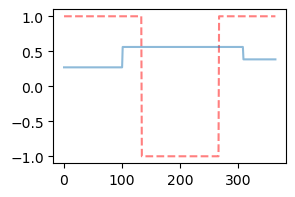

In [12]:
plt.figure(figsize=(3,2))
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_wrong_365"], alpha=0.5);

### W/ max seas constraint  

In [13]:
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", seas_max=0.5, return_obj=True) # is this reasonable?

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_seas_max_365", "expected_s_seas_mosek_seas_max_365","expected_obj_val_mosek_seas_max_365"]

### W/ signal w/ len > 365
### Default

In [14]:
signal_730 = test_df["test_signal"].array

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", return_obj=True)
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas
test_df["expected_obj_val_mosek"] = obj_val

### W/ select indices 

In [15]:
# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

### Yearly periodic

In [16]:
# yearly periodic constraint, len has to be >365
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730,  c1=1, solver = "MOSEK", yearly_periodic=True, return_obj=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

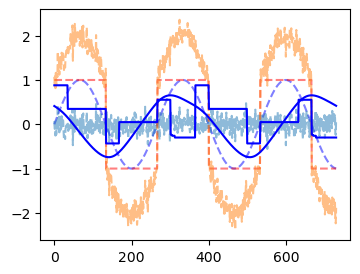

In [21]:
# tweak l1 params if off
plt.figure(figsize=(4,3))
plt.plot(signal1, linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_mosek_yearly_periodic"], color="blue")
plt.plot(test_df["expected_s_hat_mosek_yearly_periodic"], color="blue");

## Save 

In [19]:
test_df = test_df.round(7)

fname = "test_l2_l1d1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of l1_l2d2p365

In [32]:
"""
'l1_l2d2p365': estimating a smooth, seasonal component with a laplacian
noise model, fitting a local median instead of a local average
    - l1: laplacian noise, sum-of-absolute values or l1-norm
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [39]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12)

In [41]:
t = np.linspace(0, 1000, 365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# laplacian noise
signal2 = 0.15 * np.random.laplace(0, 1, len(signal1))

X_real[0] = signal2
X_real[1] = signal1

y = np.sum(X_real, axis=0)

In [42]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [43]:
# take signal <365
signal_365 = test_df["test_signal"].array[:365]

# default 
s_seas, obj_val = sd.l1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

In [44]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [45]:
# yearly periodic and >365
s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=True, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

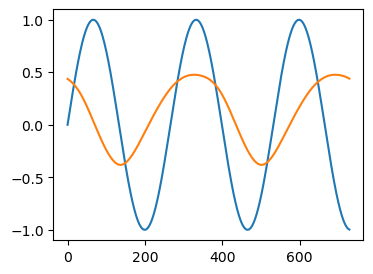

In [46]:
plt.figure(figsize=(4,3))
plt.plot(signal1)
plt.plot(s_seas);

## Save

In [47]:
test_df = test_df.round(7)
fname = "test_l1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of tl1_l2d2p365

In [50]:
"""
'tl1_l2d2p365': similar to (2), estimating a smooth, seasonal component with
an asymmetric laplacian noise model, fitting a local quantile instead of a
local average
    - tl1: 'tilted l1-norm,' also known as quantile cost function
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [74]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [75]:
from scipy.stats import laplace_asymmetric
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12)

In [76]:
t = np.linspace(0, 1000, 365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# asymmetric laplacian noise
kappa = 2 # k>0, k=1 is laplace
signal2 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = signal2
X_real[1] = signal1

y = np.sum(X_real, axis=0)

In [77]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]

In [78]:
# default 
s_seas, obj_val = sd.tl1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

In [79]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [80]:
# yearly periodic and >365
s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=True, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

## Save

In [82]:
test_df = test_df.round(7)
fname = "test_tl1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of tl1_l1d1_l2d2p365

In [86]:
"""
'tl1_l1d1_l2d2p365': like (1) but with an asymmetric residual cost instead
of Gaussian residuals
    - tl1: 'tilted l1-norm,' also known as quantile cost function
    - l1d1: piecewise constant heuristic, l1-norm of first order differences
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric

from solardatatools import signal_decompositions as sd

np.random.seed(12)

In [58]:
t = np.linspace(0, 1000, 365*2)

# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
# asymmetric laplace noise 
kappa = 2 # k>0, k=1 is laplace
signal0 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal0
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)

In [59]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]

In [60]:
# default 
s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, tau=0.995, c1=1000, c2=100, c3=100, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365", "expected_s_seas_mosek_365", "expected_obj_val_mosek_365"]

(0.0, 365.0)

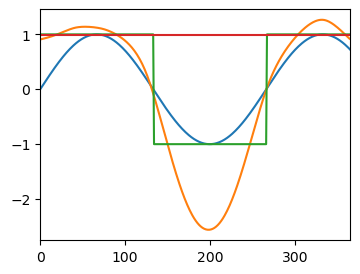

In [61]:
plt.figure(figsize=(4,3))
plt.plot(signal1)
plt.plot(s_seas)
plt.plot(signal2)
plt.plot(s_hat)
plt.xlim(0,365)

In [62]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [63]:
# random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(rand_residual_weights), pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

In [64]:
s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, solver = "MOSEK",return_obj=True, residual_weights=test_df["rand_residual_weights_365"].dropna())

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365", "expected_obj_val_mosek_rw_365"]

s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True, tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat), pd.Series(s_seas), pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365", "expected_obj_val_mosek_tvw_365"]

## Save

In [65]:
test_df = test_df.round(7)
fname = "test_tl1_l1d1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')